### [Time Series Forecasting for Retail Sales](https://medium.com/@kylejones_47003/time-series-forecasting-for-retail-sales-with-mlp-arima-kan-and-chronos-258abbbf4779)

Retail forecasting is high-stakes. Misses mean stockouts, markdowns, or investor panic. ARIMA is the legacy tool: fast, interpretable, consistent. Newer models like LSTMs and KANs claim to capture nonlinearity. Transformers promise everything.

In [1]:
!pip install -q pandas pandas-datareader numpy matplotlib seaborn
!pip install -q scikit-learn torch statsmodels pykan chronos-forecasting

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import datetime
import random
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from statsmodels.tsa.arima.model import ARIMA
from pandas_datareader import data as web
from sklearn.metrics import mean_squared_error, mean_absolute_error
from kan import KAN
from chronos import ChronosPipeline
import time

In [4]:
# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [5]:
# Unified config
prediction_length = 12
window = 24

In [6]:
# Load and preprocess data
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2025, 4, 1)
series = web.DataReader("RSAFS", "fred", start, end).dropna()["RSAFS"]
series.index.freq = "MS"

mean_val, std_val = series.mean(), series.std()
norm_series = (series - mean_val) / std_val

In [7]:
def make_lagged(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series.iloc[i:i + window].values)
        y.append(series.iloc[i + window])
    return np.array(X), np.array(y)

In [8]:
# Split
split = series.index[-(window + prediction_length)]
train_raw, test_raw = series[series.index <= split], series[series.index > split]
train_norm, test_norm = norm_series[norm_series.index <= split], norm_series[norm_series.index > split]

X_train, y_train = make_lagged(train_norm, window)
X_test, y_test = make_lagged(test_norm, window)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)

In [9]:
# ARIMA
start_arima = time.time()
arima = ARIMA(train_raw, order=(5, 1, 0)).fit()
pred_arima = arima.forecast(steps=prediction_length)
pred_arima.index = test_raw.index[:prediction_length]
arima_time = time.time() - start_arima

In [10]:
# MLP
class MLP(nn.Module):
    def __init__(self, dim):
        super().__init__();
        self.net = nn.Sequential(nn.Linear(dim, 64), nn.Tanh(), nn.Dropout(0.2), nn.Linear(64, 1))
    
    def forward(self, x):
        return self.net(x)

mlp = MLP(window)
opt = torch.optim.Adam(mlp.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

start_mlp = time.time()
for _ in range(200):
    mlp.train();
    opt.zero_grad()
    loss = loss_fn(mlp(X_train_t), y_train_t);
    loss.backward();
    opt.step()

mlp_time = time.time() - start_mlp

mlp.eval();
pred_mlp = mlp(X_test_t).squeeze().detach().numpy()

In [11]:
# KAN
kan = KAN([window, 32, 1], grid=3, k=2)
opt_kan = torch.optim.Adam(kan.parameters(), lr=0.01)

start_kan = time.time()
for _ in range(200):
    kan.train();
    opt_kan.zero_grad()
    loss = loss_fn(kan(X_train_t), y_train_t);
    loss.backward(); opt_kan.step()

kan_time = time.time() - start_kan

kan.eval(); pred_kan = kan(X_test_t).squeeze().detach().numpy()

checkpoint directory created: ./model
saving model version 0.0


In [12]:
# LSTM
class LSTM(nn.Module):
    def __init__(self, dim, h=32):
        super().__init__()
        self.lstm = nn.LSTM(dim, h, batch_first=True)
        self.fc = nn.Linear(h, 1)

    def forward(self, x):
        return self.fc(self.lstm(x)[0][:, -1])

X_train_lstm = X_train_t.unsqueeze(-1)
X_test_lstm = X_test_t.unsqueeze(-1)
lstm = LSTM(1)
opt_lstm = torch.optim.Adam(lstm.parameters(), lr=0.01)

start_lstm = time.time()
for _ in range(200):
    lstm.train()
    opt_lstm.zero_grad()
    loss = loss_fn(lstm(X_train_lstm), y_train_t)
    loss.backward()
    opt_lstm.step()

lstm_time = time.time() - start_lstm

lstm.eval(); pred_lstm = lstm(X_test_lstm).squeeze().detach().numpy()

In [13]:
# Inverse transform
y_test_actual = y_test * std_val + mean_val
valid_length = min(len(y_test_actual), prediction_length)
y_actual = y_test_actual[-valid_length:]
pred_mlp = pred_mlp[-valid_length:] * std_val + mean_val
pred_kan = pred_kan[-valid_length:] * std_val + mean_val
pred_lstm = pred_lstm[-valid_length:] * std_val + mean_val

In [14]:
# Chronos T5
device = "cuda" if torch.cuda.is_available() else "cpu"
chronos_pipe = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map=device,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32
)
context = torch.tensor(series.loc[:split].values, dtype=torch.float32)
forecast = chronos_pipe.predict(context, prediction_length=prediction_length)
pred_chronos = forecast[0].median(dim=0).values.numpy()
chronos_time = 0.0
pred_chronos = pred_chronos[-valid_length:]

In [15]:
# Metrics
def mape(y, yhat):
    return np.mean(np.abs((y - yhat) / (y + 1e-10))) * 100

def evaluate(y, yhat):
    return (mean_squared_error(y, yhat) / 1e6, mean_absolute_error(y, yhat) / 1e6, mape(y, yhat))

In [16]:
models = ["ARIMA", "MLP", "KAN", "LSTM", "Chronos T5"]
preds = [
    pred_arima[:valid_length],
    pred_mlp,
    pred_kan,
    pred_lstm,
    pred_chronos
]

times = [arima_time, mlp_time, kan_time, lstm_time, chronos_time]
results = pd.DataFrame([evaluate(y_actual, p) + (t,) for p, t in zip(preds, times)],
                       columns=["RMSE (M USD)", "MAE (M USD)", "MAPE (%)", "Train Time (s)"],
                       index=models)

In [17]:
# Plot
# Define forecast boundary and zoom range
prediction_start_date = series.index[-prediction_length]
zoom_start_date = series.index[-24]  
series_zoom = series[series.index >= zoom_start_date]

# Get valid forecast window (based on shortest forecastable length)
valid_length = min(
    prediction_length,
    len(pred_arima),
    len(pred_mlp),
    len(pred_kan),
    len(pred_lstm),
    len(pred_chronos)
)

In [18]:
# Plot
# Define forecast boundary and zoom range
prediction_start_date = series.index[-prediction_length]
zoom_start_date = series.index[-24]  
series_zoom = series[series.index >= zoom_start_date]

# Get valid forecast window (based on shortest forecastable length)
valid_length = min(
    prediction_length,
    len(pred_arima),
    len(pred_mlp),
    len(pred_kan),
    len(pred_lstm),
    len(pred_chronos)
)

forecast_index = series.index[series.index >= prediction_start_date][:valid_length]
end_date = forecast_index[-1]

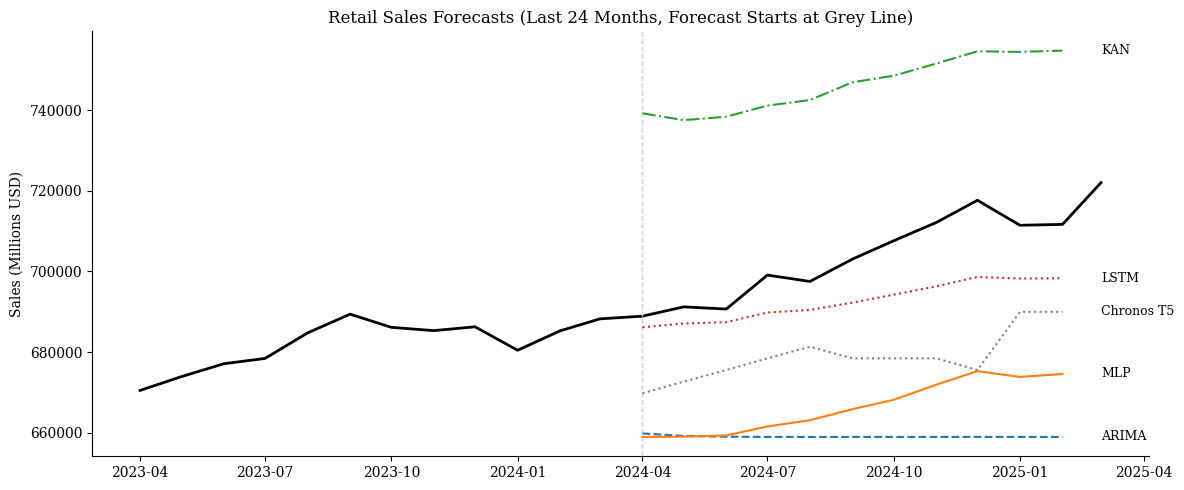

        Model  RMSE (M USD)  MAE (M USD)  MAPE (%)  Train Time (s)
0       ARIMA   2288.324457     0.046770  6.607518        0.066584
1         MLP   1570.733952     0.039325  5.564087        0.309601
2         KAN   1662.732449     0.040505  5.747465       38.772187
3        LSTM    210.103071     0.013199  1.858936        4.057398
4  Chronos T5    771.063953     0.026860  3.795010        0.000000


In [19]:
# Plot setup
plt.rcParams.update({
    "font.family": "serif",
    "axes.spines.top": False,
    "axes.spines.right": False
})
fig, ax = plt.subplots(figsize=(12, 5))

# Plot actual series (last 24 months)
ax.plot(series_zoom.index, series_zoom.values, label="Actual", color="black", linewidth=2)

# Add forecast start boundary
ax.axvline(prediction_start_date, color="lightgray", linestyle="--", linewidth=1)

# Forecast lines
ax.plot(forecast_index, pred_arima[:valid_length], linestyle="--", linewidth=1.5)
ax.plot(forecast_index, pred_mlp[-valid_length:], linewidth=1.5)
ax.plot(forecast_index, pred_kan[-valid_length:], linestyle="-.", linewidth=1.5)
ax.plot(forecast_index, pred_lstm[-valid_length:], linestyle=":", linewidth=1.5)
ax.plot(forecast_index, pred_chronos[-valid_length:], linestyle="dotted", linewidth=1.5)

def add_forecast_label(y_vals, label, offset=0):
    ax.text(end_date + pd.DateOffset(months=1),
            y_vals[-1] + offset,
            label,
            fontsize=9, va='center', ha='left')

add_forecast_label(pred_arima[:valid_length], "ARIMA")
add_forecast_label(pred_mlp[-valid_length:], "MLP")
add_forecast_label(pred_kan[-valid_length:], "KAN")
add_forecast_label(pred_lstm[-valid_length:], "LSTM")
add_forecast_label(pred_chronos[-valid_length:], "Chronos T5")

# Formatting
ax.set_ylabel("Sales (Millions USD)")
ax.set_title("Retail Sales Forecasts (Last 24 Months, Forecast Starts at Grey Line)")
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.tight_layout()
# plt.savefig("retail_forecast_stream_labels_zoom.png", dpi=300)
plt.show()

results.reset_index(names="Model", inplace=True)
with pd.option_context('display.max_rows', None,):
    print(results)